# TP2 de control opitimale

## Modèle SIR, stratégie optimale de confinement


$$
\begin{cases}
S'(t) = -u(t) \frac{S(t)I(t)}{N(t)}, & t \geq 0 \\
I'(t) = u(t) \frac{S(t)I(t)}{N(t)} - \beta I(t), \\
R'(t) = \beta I(t),
\end{cases}
$$

avec $N = S + I + R$ la population totale (constante) et les conditions initiales:

$$
(S(0), I(0), R(0)) = (S_0, I_0, R_0)
$$


1. On utilise la fonctionnelle de coût suivante:
   $$
   L_\tau (u) = \tau \int_0^T g(u(t)) \, dt + (1 - \tau) \int_0^T f(I(t)) \, dt
   $$
   où $g$ represente le coût de confinement et $f$ le coût lié au nombre de personnes infectées. D'où le choix de minimiser la combinaison convexe de ces deux termes.


2. Vérifions que $N = S(t) + I(t) + R(t)$ est constante:
   $$
   \begin{aligned}
   N'(t) &= S'(t) + I'(t) + R'(t) \\
   &= -u(t) \frac{S(t)I(t)}{N(t)} + u(t) \frac{S(t)I(t)}{N(t)} - \beta I(t) + \beta I(t) \\
   &= 0
   \end{aligned}
   $$

Donc $N$ est constante.


3. Cas de controles constants:


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gekko import GEKKO

In [38]:
def RK4(f, y0, t0, tf, dt, u):
    t = np.arange(t0, tf + dt, dt)  # Ensure final time is included
    y = np.zeros((len(t), len(y0)))  # Initialize solution array
    y[0] = y0  # Set initial condition

    for i in range(1, len(t)):
        # Use the control value corresponding to the current time step
        u_t = u[i - 1]

        # Compute RK4 steps
        k1 = dt * f(y[i - 1], u_t)
        k2 = dt * f(y[i - 1] + 0.5 * k1, u_t)
        k3 = dt * f(y[i - 1] + 0.5 * k2, u_t)
        k4 = dt * f(y[i - 1] + k3, u_t)

        # Update the state
        y[i] = y[i - 1] + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return t, y


def SIR(y, u):
    beta = 0.1
    S, I, R = y
    N = S + I + R
    dS = -u * S * I / N
    dI = u * S * I / N - beta * I
    dR = beta * I
    return np.array([dS, dI, dR])

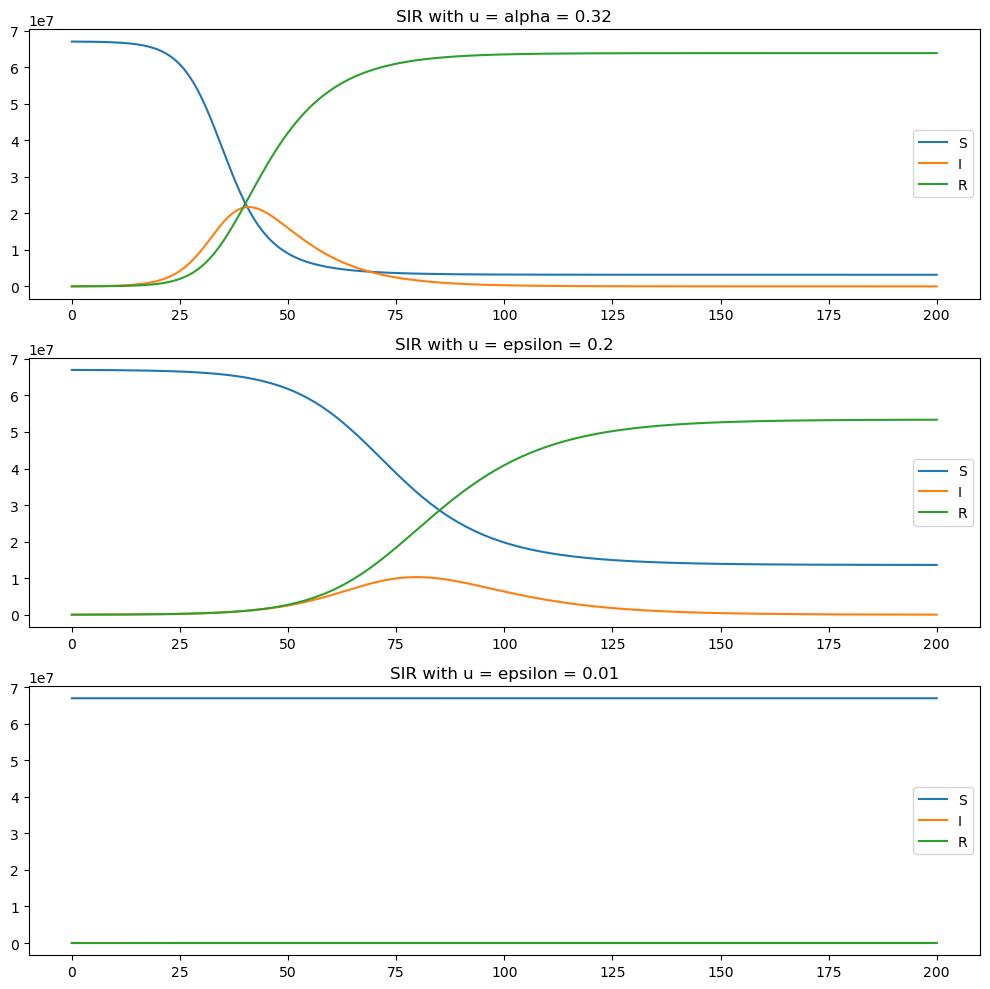

In [39]:
# Solve SIR using RK4
S0 = 6.7e7 - 2e4
I0 = 2e4
R0 = 0
alpha = 0.32
epsilon = [0.2, 0.01]
T = 200
dt = 1

y0 = np.array([S0, I0, R0])
u01 = np.array([alpha] * int(T / dt))
u02 = np.array([epsilon[0]] * int(T / dt))
u03 = np.array([epsilon[1]] * int(T / dt))

t, y = RK4(SIR, y0, 0, T, dt=dt, u=u01)
t2, y2 = RK4(SIR, y0, 0, T, dt=dt, u=u02)
t3, y3 = RK4(SIR, y0, 0, T, dt=dt, u=u03)

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].plot(t, y[:, 0], label="S")
axs[0].plot(t, y[:, 1], label="I")
axs[0].plot(t, y[:, 2], label="R")
axs[0].set_title("SIR with u = alpha = 0.32")
axs[0].legend()

axs[1].plot(t2, y2[:, 0], label="S")
axs[1].plot(t2, y2[:, 1], label="I")
axs[1].plot(t2, y2[:, 2], label="R")
axs[1].set_title("SIR with u = epsilon = 0.2")
axs[1].legend()

axs[2].plot(t3, y3[:, 0], label="S")
axs[2].plot(t3, y3[:, 1], label="I")
axs[2].plot(t3, y3[:, 2], label="R")
axs[2].set_title("SIR with u = epsilon = 0.01")
axs[2].legend()

fig.tight_layout()
plt.show()

On remarque qu'avec

- $u = \epsilon = 0.2$, la vague de l'épidémie est plus lente avec un pic moins élevé.
- $u = \epsilon = 0.1$, la vague ne semble jamais arriver car la population est confiné, il n'y a pas d'infectés.


4. Calcul du gradient de $L_\tau$ par rapport à $u$:

On a:

$$
\begin{aligned}
X' = F(X, u) \\
\Leftrightarrow  \begin{pmatrix} S' \\ I' \\ R' \end{pmatrix} =  F(X,u) \\
L_\tau(u) = \tau \int_0^T g(u(t)) \, dt + (1 - \tau) \int_0^T f(I(t)) \, dt
\end{aligned}
$$

On cherche $DL_\tau(u)h$ sous la forme:

$$
DL_\tau(u)h =  <\underbrace{machin}_{\nabla L_\tau(u) }, h> \\
$$

On a:

$$
\begin{cases}
\dot{X}  = DX(u)h \\
Du(u)h = h = \dot{u}
\end{cases}
$$

Donc:

$$
DL_\tau(u)h = \tau\int_0^T g'(u(t))h(t) \, dt + (1 - \tau) \int_0^T f'(I(t))\dot{X} \, dt
$$

En dérivant $\dot{X}$ on obtient:

$$
\dot{X}^{'} = \partial_X F(X, u) \dot{X} + \partial_u F(X, u) \dot{u} \\
\Leftrightarrow \dot{X}^{'} = \partial_X F(X, u) \dot{X} + \partial_u F(X, u) h \\
\Leftrightarrow \dot{X}^{'} = \underbrace{ \begin{pmatrix} -u \frac{I}{N} & -u \frac{S}{N} & 0 \\ u \frac{I}{N} & u \frac{S}{N} - \beta & 0 \\ 0 & \beta & 0 \end{pmatrix}}_{A} \dot{X} + \underbrace{\begin{pmatrix} -\frac{SI}{N} \\ \frac{S I}{N} \\ 0 \end{pmatrix}}_{B} h \\
\Leftrightarrow \dot{X}^{'} = A \dot{X} + B h
$$

On pose alors le problème de Cauchy suivant:

$$
\begin{cases}
\dot{X}^{'} = A \dot{X} + B h \\
\dot{X}(0) = 0
\end{cases}
$$

Et on introduit le dual:

$$
\begin{cases}
-P^{'} = A^T P + truc1 \\
P(T) = truc2
\end{cases}
$$

En multipliant le problème de Cauchy par $P$ et en intégrant on obtient:

$$
\int_0^T <\dot{X}^{'}, P> \, dt = \int_0^T <A \dot{X}, P + B h> \, dt \\
$$

Une IPP sur le premier terme donne:

$$
- \int_0^T <\dot{X}, P'> + \dot{X}(T)\underbrace{P(T)}_{truc2} - \underbrace{\dot{X}(0)}_{0}P(0) \\
 = \int_0^T <\dot{X}, A^T P> + \underbrace{\int_0^T <\dot{X}, truc1> + \dot{X}(T)truc2}_{\int_0^T <Bh, P>}
$$

On pose alors:

$$
\begin{cases}
truc1 = f'(I) \\
truc2 = 0
\end{cases}
$$

Et on obtient:

$$
\int_0^T <B^TP, h> \, dt = \int_0^T <\dot{X}, f'(I)> \, dt
$$

Donc:

$$
DL_\tau(u)h = \tau\int_0^T g'(u)h  + (1 - \tau) \int_0^T <\dot{X}, f'(I)>  \\
= \tau\int_0^T g'(u)h + (1 - \tau) \int_0^T <B^TP, h> \\
= \int_0^T h\left( \tau g'(u) + (1 - \tau) B^TP \right)
$$

Avec $P = \begin{pmatrix} P_1 \\ P_2 \\ P_3 \end{pmatrix}$, on a:

$$
B^TP = \begin{pmatrix} -\frac{SI}{N} & \frac{SI}{N} & 0 \end{pmatrix} \begin{pmatrix} P_1 \\ P_2 \\ P_3 \end{pmatrix} = -\frac{SI}{N}P_1 + \frac{SI}{N}P_2
$$

Donc:

$$
DL_\tau(u)h = \int_0^T h\left( \tau g'(u) + (1 - \tau) \frac{SI}{N} \left( P_2 - P_1\right) \right)
$$


5. Mise en oeuvre d'une methode de gradient:


In [40]:
def g(u):
    alpha = 0.32
    return 0.5 * (alpha**2 - u**2)


def g_prime(u):
    return -u


def f(I):
    return I


def f_prime(I):
    return np.ones_like(I)


def A(u, SIR, beta):
    S, I, R = SIR
    N = S + I + R
    return np.array(
        [[-u * I / N, -u * S / N, 0], [u * I / N, u * S / N - beta, 0], [0, beta, 0]]
    )

In [41]:
def RK4_adj(f, P0, t0, tf, dt, u, SIR_values):
    t = np.arange(tf, t0 - dt, -dt)  # Backward time array
    P = np.zeros((len(t), len(P0)))  # Initialize adjoint variables
    P[0] = P0  # Final-time condition for adjoint variables

    for i in range(1, len(t)):
        # Use the control value corresponding to the current time step
        u_t = u[-i]

        # Compute RK4 steps
        k1 = dt * f(P[i - 1], u_t, SIR_values[-i])
        k2 = dt * f(P[i - 1] + 0.5 * k1, u_t, SIR_values[-i])
        k3 = dt * f(P[i - 1] + 0.5 * k2, u_t, SIR_values[-i])
        k4 = dt * f(P[i - 1] + k3, u_t, SIR_values[-i])

        # Update the adjoint variable
        P[i] = P[i - 1] + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return t, P


def adjoint_system(P, u, SIR):
    beta = 0.1
    return -A(u, SIR, beta).T @ P - np.array([0, f_prime(SIR[1]), 0])


# "Initial" conditon, P(T)=0
P0 = np.array([0, 0, 0])

# Solve the adjoint system backward in time
u0 = np.array([alpha] * int(T / dt))
t_adj, P = RK4_adj(adjoint_system, P0, 0, T, dt=dt, u=u0, SIR_values=y)
print(P.shape)

(201, 3)


In [42]:
def gradL(u, tau, SIR_t, P):
    S = SIR_t[:, 0]
    I = SIR_t[:, 1]
    R = SIR_t[:, 2]
    P1 = P[:, 0]
    P2 = P[:, 1]
    N = S + I + R
    grad = tau * g_prime(u) + (1 - tau) * S * I / N * (P2 - P1)
    return grad


def L_tau(u, tau, SIR):
    _, I, _ = SIR.T  # Transpose to extract S, I, R as arrays
    term1 = tau * g(u)  # Control effort term
    term2 = (1 - tau) * f(I)  # Infected penalty term
    return np.trapezoid(term1 + term2, dx=dt)  # Integrate over time

In [89]:
def gradient_descent_projection(tau, u0, y0, rho0, max_iter=1000, tol=1e-5):
    alpha = 0.32  # Maximum control value
    u = u0.copy()  # Copy the initial control array
    L_values = []  # Store objective values
    k = 0  # Iteration counter

    # Compute initial state trajectory and adjoint variables
    _, y = RK4(SIR, y0, 0, T, dt=dt, u=u)
    _, P = RK4_adj(adjoint_system, P0, 0, T, dt=dt, u=u, SIR_values=y)

    while k < max_iter:
        grad = gradL(u, tau, y, P)

        rho = rho0
        u_new = np.clip(u - rho * grad, a_min=0, a_max=alpha)

        _, y_new = RK4(SIR, y0, 0, T, dt=dt, u=u_new)
        _, P_new = RK4_adj(adjoint_system, P0, 0, T, dt=dt, u=u_new, SIR_values=y_new)

        L_new = L_tau(u_new, tau, y_new)
        L_old = L_tau(u, tau, y)

        delta = L_new - L_old

        cpt = 0
        while delta <= 0 and cpt < 100:
            rho = rho / 1.3
            u_new = np.clip(u - rho * grad, a_min=0, a_max=alpha)
            _, y_new = RK4(SIR, y0, 0, T, dt=dt, u=u_new)
            _, P_new = RK4_adj(
                adjoint_system, P0, 0, T, dt=dt, u=u_new, SIR_values=y_new
            )
            L_new = L_tau(u_new, tau, y_new)
            delta = L_new - L_old
            cpt += 1
            # print(f"Iteration {k}, Step {cpt}: delta={delta:.6f}, rho={rho:.6f}")


        u = u_new
        y = y_new
        P = P_new

        L_values.append(L_new)

        # grad_norm = np.linalg.norm(grad)
        criterion = np.abs((L_new - L_old) / (L_old+1e-6))
        
        # print("grad_norm", grad_norm)
        # print("criteron", criterion)

        if criterion < tol:
            break

        k += 1

    converged = k < max_iter
    return u, converged, k, L_values

J'ai du mal à trouver les bon paramètre et le bon critère d'arret ....

In [90]:
tau_values = 1
rho0 = 1 # Initial time step
max_iter = 100
T = 90
u = np.array([alpha] * int(T / dt + 1))

u_opt, converged, k, L_values = gradient_descent_projection(
    tau_values, u, y0, rho0, max_iter, tol=1e-5
)

print(f"Converged: {converged}")
print(f"Iterations: {k}")
print(f"Objective value: {L_values[-1]}")
print(f"Optimal control: {u_opt}")

Converged: True
Iterations: 0
Objective value: 0.0
Optimal control: [0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32
 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32
 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32
 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32
 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32
 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32
 0.32 0.32 0.32 0.32 0.32 0.32 0.32]


In [93]:
tau_values = 0.5
rho0 = 1 # Initial time step
max_iter = 100
T = 90
u = np.array([alpha/2] * int(T / dt + 1))

u_opt, converged, k, L_values = gradient_descent_projection(
    tau_values, u, y0, rho0, max_iter, tol=1e-5
)

print(f"Converged: {converged}")
print(f"Iterations: {k}")
print(f"Objective value: {L_values[-1]}")
print(f"Optimal control: {u_opt}")

Converged: False
Iterations: 100
Objective value: 314339455.460064
Optimal control: [0.24       0.32       0.32       0.32       0.32       0.32
 0.32       0.32       0.32       0.32       0.32       0.32
 0.32       0.32       0.32       0.32       0.32       0.32
 0.32       0.32       0.32       0.32       0.32       0.32
 0.32       0.32       0.32       0.32       0.32       0.32
 0.32       0.32       0.32       0.32       0.32       0.32
 0.32       0.32       0.32       0.32       0.32       0.32
 0.32       0.32       0.32       0.32       0.32       0.32
 0.32       0.32       0.32       0.32       0.32       0.32
 0.32       0.32       0.32       0.32       0.32       0.32
 0.30633545 0.29689446 0.2910373  0.28797216 0.28696606 0.28739155
 0.28874529 0.29064568 0.29281816 0.29507516 0.29729564 0.29940699
 0.30137028 0.303169   0.30480083 0.30627194 0.30759313 0.30877727
 0.30983782 0.31078785 0.31163955 0.31240404 0.31309124 0.31370998
 0.31426798 0.31477202 0.31522805 0.31

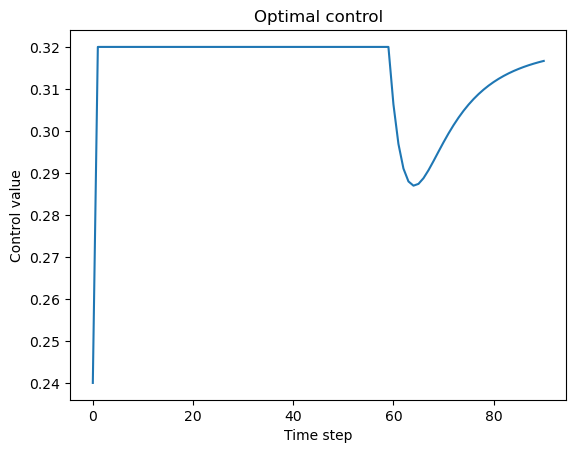

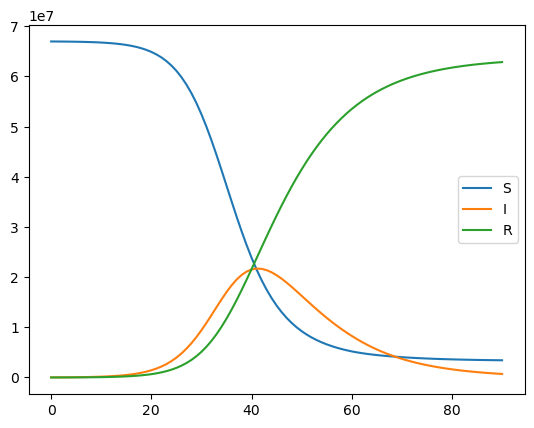

In [94]:
# Plot the optimal control
plt.plot(u_opt)
plt.xlabel("Time step")
plt.ylabel("Control value")
plt.title("Optimal control")
plt.show()

# PLot SIR
t, y = RK4(SIR, y0, 0, T, dt=dt, u=u_opt)
plt.plot(t, y[:, 0], label="S")
plt.plot(t, y[:, 1], label="I")
plt.plot(t, y[:, 2], label="R")
plt.legend()
plt.show()

In [95]:
# tau_values = [0, 0.5, 1]
# max_iter = 100
# T = 90

# # Different initializations for u0
# initializations = {
#     "no lockdown": 0.32,  # u0(t) = alpha
#     "medium lockdown": 0.16,  # u0(t) = alpha / 2
#     "strong lockdown": 0.01,  # u0(t) = epsilon
# }

# results_list = []

# # Iterate over tau values and initializations
# for tau in tau_values:
#     for init_name, u0 in initializations.items():
#         u0 = np.array([u0] * int(T / dt + 1))
#         u_opt, converged, iters, L_values = gradient_descent_projection(
#             tau, u0, y0, rho0, max_iter
#         )

#         # Append results as a dictionary to the list
#         results_list.append(
#             {
#                 "tau": tau,
#                 "initialization": init_name,
#                 "u_opt": u_opt,
#                 "converged": converged,
#                 "iterations": iters,
#                 "L_values": L_values,
#             }
#         )

# # Convert list of dictionaries to a dataframe
# results_df = pd.DataFrame(results_list)

# print(results_df.drop(columns=["L_values"]))

In [96]:
# # Plotting Criterion Evolution
# for tau in tau_values:
#     plt.figure(figsize=(12, 6))
#     subset_df = results_df[results_df["tau"] == tau]

#     for idx, row in subset_df.iterrows():
#         plt.plot(
#             row["L_values"],
#             label=f"{row['initialization']} (u0={initializations[row['initialization']]}) - L_tau",
#         )

#     plt.xlabel("Iteration")
#     plt.ylabel("Criterion L_tau")
#     plt.title(f"Criterion Evolution for tau = {tau}")
#     plt.legend()
#     plt.show()

# # Plotting SIR trajectories for each initialization strategy
# for tau in tau_values:
#     for init_name in initializations.keys():
#         plt.figure(figsize=(12, 6))

#         # Get the subset for the current tau and initialization
#         subset_df = results_df[
#             (results_df["tau"] == tau) & (results_df["initialization"] == init_name)
#         ]

#         # Plot SIR trajectories
#         for idx, row in subset_df.iterrows():
#             u_opt = row["u_opt"]
#             t, y = RK4(SIR, y0, 0, T, dt=dt, u=u_opt)

#             plt.plot(t, y[:, 0], label="S")
#             plt.plot(t, y[:, 1], label="I")
#             plt.plot(t, y[:, 2], label="R")

#         plt.xlabel("Time")
#         plt.ylabel("Population")
#         plt.title(f"SIR Trajectories for tau = {tau} and {init_name} Strategy")
#         plt.legend()
#         plt.show()

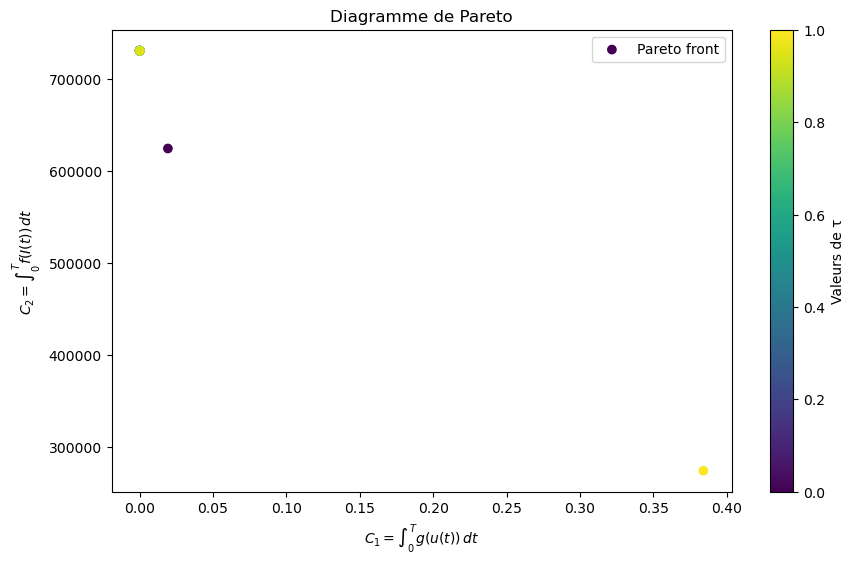

In [102]:
# 7
# (a) Pareto diagram

tau_values = np.linspace(0, 1, 20)
C1_values = []
C2_values = []

T = 10
t = np.arange(0, T, dt)
u0 = np.array([alpha / 2] * int(T / dt + 1))

for tau in tau_values:
    u_opt, _, _, _ = gradient_descent_projection(tau, u0, y0, rho0, max_iter)

    t, y = RK4(SIR, y0, 0, T, dt=dt, u=u_opt)

    I_values = y[:, 1]  # Infectés I(t)
    C1 = np.trapezoid(g(u_opt), dx=dt)  # Integral of g(u(t))
    C2 = np.trapezoid(f(I_values), dx=dt)  # Integral of f(I(t))

    # Store the values
    C1_values.append(C1)
    C2_values.append(C2)

plt.figure(figsize=(10, 6))
sc = plt.scatter(
    C1_values, C2_values, c=tau_values, cmap="viridis", label="Pareto front"
)
plt.colorbar(sc, label="Valeurs de τ")
plt.xlabel(r"$C_1 = \int_0^T g(u(t)) \, dt$")
plt.ylabel(r"$C_2 = \int_0^T f(I(t)) \, dt$")
plt.title("Diagramme de Pareto")
plt.legend()
plt.show()

On remarque que plus $\tau$ est petit, plus $\int_0^T g(u(t)) \, dt$ est petit par rapport à $\int_0^T f(I(t)) \, dt$ et donc le controle est plus orienté vers la minimisation de $f(I(t))$ le coût lié au nombre de personnes infectées.


/tmp/ipykernel_129647/723583645.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  u_opt = np.array(u.value)


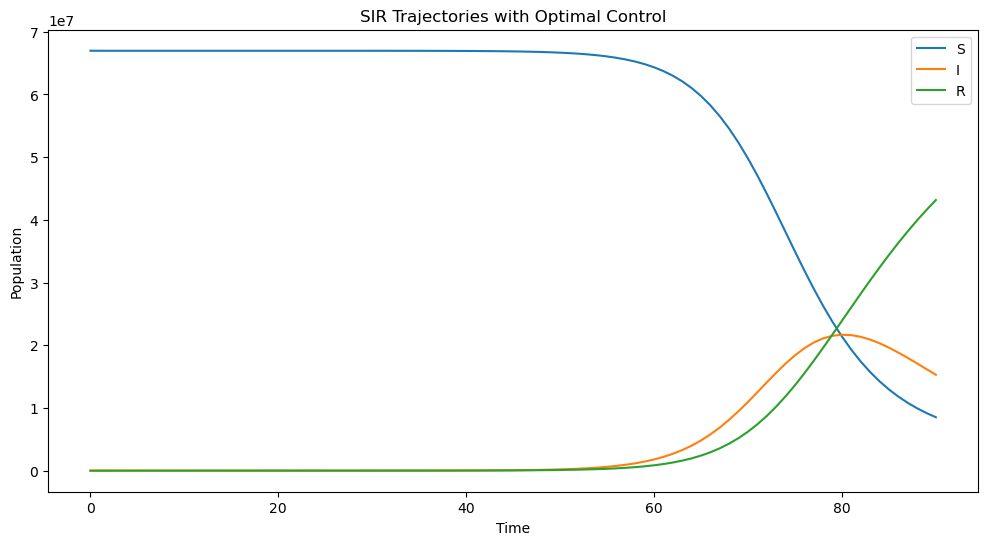

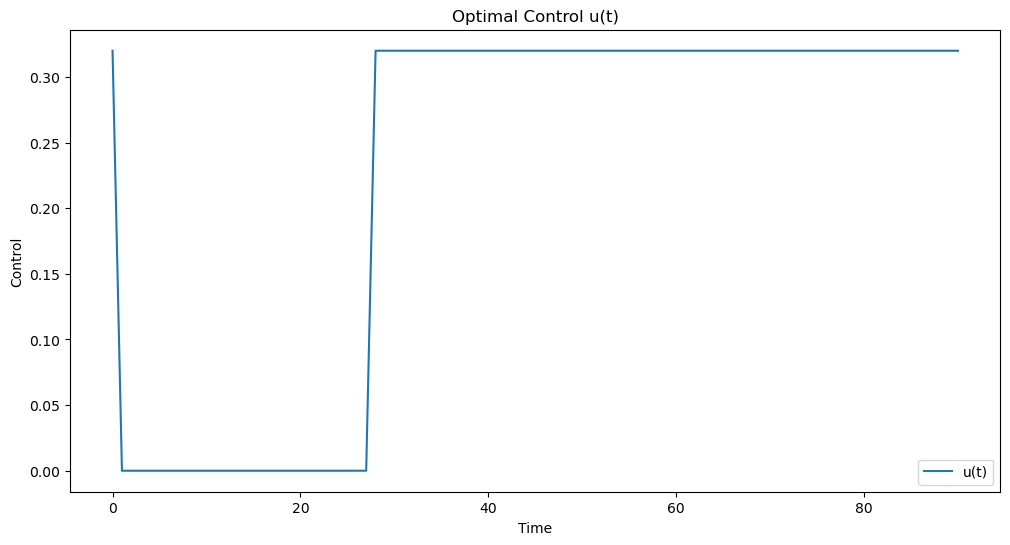

In [98]:
T = 90  # Total time
dt = 1  # Time step
time = np.linspace(0, T, int(T / dt) + 1)

# Parameters
beta = 0.5  # Elimination rate
alpha = 0.32  # Maximum control effort
tau = 0.7  # Trade-off parameter

# Initialize Gekko model
m = GEKKO(remote=True)
m.time = time


# Variables
S = m.Var(value=6.7e7 - 2e4)  # Susceptible population (initial value)
I = m.Var(value=2e4)  # Infected population (initial value)
R = m.Var(value=0.0)  # Recovered population (initial value)
N = S + I + R

# Control variable
u0 = alpha  # Initial control value
u = m.MV(value=u0, lb=0.0, ub=alpha)  # Control variable
u.STATUS = 1  # Allow optimization to control `u`

# Equations
m.Equations(
    [
        S.dt() == -u * S * I / N,  # Susceptibles
        I.dt() == u * S * I / N - beta * I,  # Infected
        R.dt() == beta * I,  # Retired
    ]
)

# Objective function
obj_control = m.integral(tau * 0.5 * (alpha**2 - u**2))  # Penalize control effort
obj_infected = m.integral((1 - tau) * 0.5 * I**2)  # Minimize infections
m.Obj(obj_control + obj_infected)

# Solver options
m.options.IMODE = 6
m.options.SOLVER = 3  # IPOPT solver


# Solve
m.solve(disp=False)


u_opt = np.array(u.value)
u_opt = u_opt.astype(float)

dt = T / (len(u_opt) - 1)
t, y = RK4(SIR, y0, 0, T, dt, u=u_opt)

plt.figure(figsize=(12, 6))
plt.plot(t, y[:, 0], label="S")
plt.plot(t, y[:, 1], label="I")
plt.plot(t, y[:, 2], label="R")
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("SIR Trajectories with Optimal Control")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(t, u_opt, label="u(t)")
plt.xlabel("Time")
plt.ylabel("Control")
plt.title("Optimal Control u(t)")
plt.legend()
plt.show()

#### (c)

Pour enrichir notre model on pourrait rajourter un temps d'incubation, un temps de guerision, ajouter une strategie de vaccination, etc.  
On pourrait aussi tester d'autres fonctions couts et d'autres methodes de gradient pour la minimisation.
